In [0]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split

import numpy as np

# Классификация

In [0]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 10, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

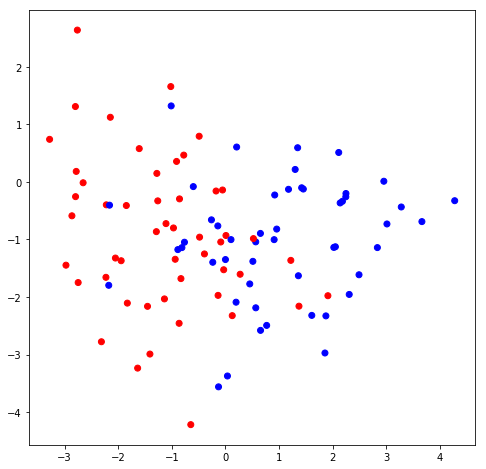

In [0]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [0]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [0]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, target, tree_type='classification'):
        self.data = data
        self.target = target
        self.tree_type = tree_type
        self.prediction = self.predict()
        
    def predict(self):
        if self.tree_type == 'regression':
            prediction = np.mean(self.target)
            return prediction
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.target:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [0]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [0]:
# Расчет дисперсии

def variance(target):
    if len(target) <= 30:
        return np.var(target, ddof=1)
    return np.var(target)

In [0]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [0]:
# Разбиение датасета в узле

def split(data, target, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_target = target[left]
    false_target = target[right]
        
    return true_data, false_data, true_target, false_target

In [0]:
# Нахождение наилучшего разбиения

def find_best_split(data, target, tree_type='classification'):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    if tree_type == 'regression':
        current_variance = variance(target)
    else:
        current_gini = gini(target)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_target, false_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            if tree_type == 'regression':
                current_quality = current_variance - variance(true_target)
            else:
                current_quality = quality(true_target, false_target, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [0]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target, max_depth=None, n_splits=0,
               max_feature_splits=None, feature_splits={},
               tree_type='classification'):

    quality, t, index = find_best_split(data, target, tree_type)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, target, tree_type)
   
    #  Ограничение на глубину
    if max_depth:
        if n_splits == max_depth:
            return Leaf(data, target, tree_type)
        n_splits += 1        
            
    # Ограничение на количество разбиений признака        
    if max_feature_splits:
        feature_splits[index] = feature_splits.setdefault(index, 0) + 1
        if max_feature_splits in feature_splits.values():
            return Leaf(data, target, tree_type)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева,
    # передавая обновляемые параметры
    true_branch = build_tree(true_data, true_target, max_depth, n_splits,
                             max_feature_splits, feature_splits, tree_type)
    false_branch = build_tree(false_data, false_target, max_depth, n_splits,
                              max_feature_splits, feature_splits, tree_type)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [0]:
def predict_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [0]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = predict_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [0]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [0]:
# Построим деревья по обучающей выборке:
# одно без ограничений, два - с реализованными ограничениями

my_tree = build_tree(train_data, train_labels)
tree_with_max_depth = build_tree(train_data, train_labels, max_depth=2)
tree_with_max_feature_splits = build_tree(train_data, train_labels, max_feature_splits=2)

In [0]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print spacing + "Прогноз: " + str(node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print spacing + 'Индекс: '+ str(node.index)
    print spacing + 'Порог: ' + str(node.t)

    # Рекурсионный вызов функции на положительном поддереве
    print  spacing + '--> True:'
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print  spacing + '--> False:'
    print_tree(node.false_branch, spacing + "  ")

In [0]:
print_tree(my_tree)

Индекс: 0
Порог: 1.2200828189524273
--> True:
  Индекс: 6
  Порог: 0.5833482249908981
  --> True:
    Индекс: 3
    Порог: -0.08738921218053775
    --> True:
      Индекс: 3
      Порог: -0.6905220685318461
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [0]:
print_tree(tree_with_max_depth)

Индекс: 0
Порог: 1.2200828189524273
--> True:
  Индекс: 6
  Порог: 0.5833482249908981
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [0]:
print_tree(tree_with_max_feature_splits)

Индекс: 0
Порог: 1.2200828189524273
--> True:
  Индекс: 6
  Порог: 0.5833482249908981
  --> True:
    Индекс: 3
    Порог: -0.08738921218053775
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [0]:
my_tree_pred = predict(test_data, my_tree)
tree_with_max_depth_pred = predict(test_data, my_tree)

print 'Доля верных ответов'
print 'tree_with_max_depth: ' + str(accuracy_score(test_labels, tree_with_max_depth_pred))
print 'my_tree: ' + str(accuracy_score(test_labels, my_tree_pred))

Доля верных ответов
tree_with_max_depth: 0.9
my_tree: 0.9


# Регрессия

In [0]:
# сгенерируем данные
n = 2
regression_data, regression_target = datasets.make_regression(n_samples=150, n_features=n,
                                                              n_informative=n, noise=1,
                                                              random_state=0)

In [0]:
train_data, test_data, train_target, test_target = train_test_split(regression_data, 
                                                                    regression_target, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

Построим дерево регресии и ограничим его глубину до четырех разбиений:

In [0]:
regression_tree = build_tree(train_data, train_target, max_depth=4, tree_type='regression')

regression_pred = predict(test_data, regression_tree)

In [0]:
print_tree(regression_tree)

Индекс: 1
Порог: -1.188859257784029
--> True:
  Индекс: 0
  Порог: 0.18877859679382855
  --> True:
    Прогноз: -102.30760411802227
  --> False:
    Прогноз: -68.2462278814056
--> False:
  Индекс: 1
  Порог: -0.8034096641738411
  --> True:
    Индекс: 0
    Порог: -0.6895497777502005
    --> True:
      Прогноз: -111.10590484038701
    --> False:
      Прогноз: -52.5030385472397
  --> False:
    Индекс: 1
    Порог: -0.5973160689653627
    --> True:
      Индекс: 0
      Порог: -0.3595531615405413
      --> True:
        Прогноз: -66.24637052785101
      --> False:
        Прогноз: -20.805830922267546
    --> False:
      Индекс: 1
      Порог: -0.3108861716984717
      --> True:
        Прогноз: -12.833168062885932
      --> False:
        Прогноз: 48.52447850252472


Построим диаграммы тестовых данных и предсказание дерева:

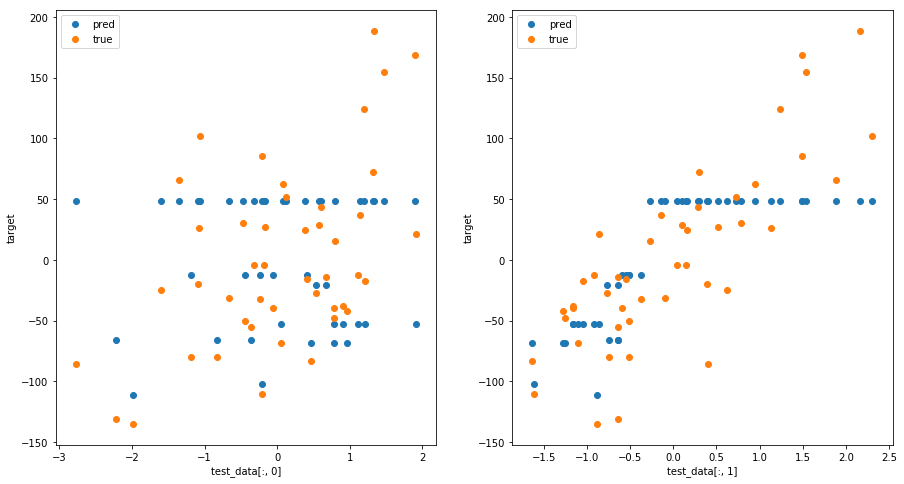

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))
for i in [0, 1]:
    axes[i].scatter(test_data[:, i], regression_pred, label='pred')
    axes[i].scatter(test_data[:, i], test_target, label='true')
    axes[i].set_xlabel('test_data[:, {}]'.format(i))
    axes[i].set_ylabel('target')
    axes[i].legend(loc='best')

Вычислим коэффициен детерминации:

In [0]:
r2_score(test_target, regression_pred)

0.4967200235866669

Он в нужных пределах (от 0 до 1).